In [1]:
from scripts import *

import numpy as np
import pandas as pd
import pystan
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


X-matching Yu18 and APOKASC...
Before: 16094
After: 16094
X-matching Yu18 and Gaia TGAS Data
Before: 16094
After: 2212
Removing negative parallaxes & those with error < 40%
Before: 2212
After: 1256


100%|██████████| 1256/1256 [00:00<00:00, 1965.64it/s]


Are you 100% certain that (all) parallax(es) is/are in units of milliarcsec?


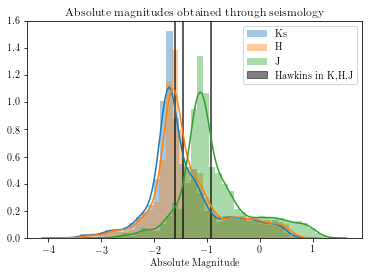

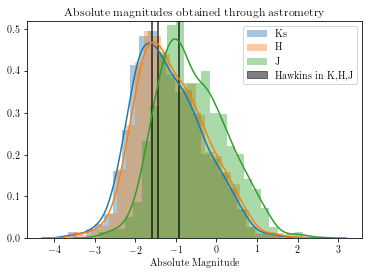

,KICID,numax,numax_err,dnu,dnu_err,Teff,Teff_err,[Fe/H],[Fe/H]_err,stage,...,ast_MKs,ast_MH,ast_MJ,ast_M_err,phot_MKs,phot_MKs_err,phot_MH,phot_MH_err,phot_MJ,phot_MJ_err
16,1160789,24.72,0.62,3.509,0.048,4724.0,80.0,-0.27,0.15,2.0,...,-1.614627,-1.524349,-0.998469,0.112440,-1.880541,0.518281,-1.814625,0.518428,-1.333162,0.518428
18,1161618,34.32,0.50,4.108,0.028,4747.0,80.0,0.08,0.15,2.0,...,-1.663921,-1.584576,-1.051163,0.089268,-1.673712,0.633360,-1.594061,0.633638,-1.040361,0.633360


In [2]:
df = get_ast_yu18()
df.head(2)


-1.1679154782703844


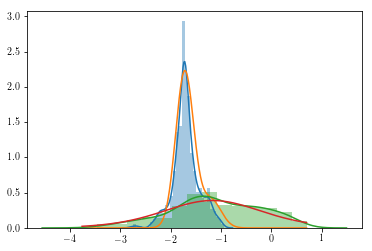

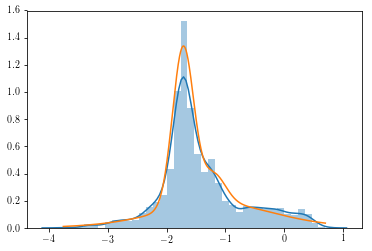

In [3]:
'''Step one is figuring out the different distributions we want'''
'''NOTE: RGB = 1 | HeB = 2 | U = 0'''
df.head(2)
Ks = df.ast_MKs.values
Ks_err = df.ast_M_err.values
stage = df.stage.values
mKs = df.K_MAG_2M.values
heb = stage == 2

x = np.linspace(Ks.min(),Ks.max(),1000)
truQ = float(len(Ks[heb]))/float(len(Ks))

print(np.median(Ks[~heb]))

# fg = normal(x, np.median(Ks[heb]),0.18) + 0.2*normal(x, -1.2,0.2)
# fg = cauchy(x, np.median(Ks[heb]), 0.1)
fg = students_t(x, 5., np.median(Ks[heb]), .2)
# bg = normal(x, np.median(Ks[~heb]),1.)
bg = students_t(x, 10., np.median(Ks[~heb]), 1.)
pp = truQ*fg + (1-truQ)*bg


sns.distplot(Ks[heb])
plt.plot(x,fg)
sns.distplot(Ks[~heb])
plt.plot(x,bg)
plt.show()

sns.distplot(Ks)
plt.plot(x,pp)
plt.show()

In [5]:
code = '''
data {
    int<lower = 0> N;
    real d[N];
    real err[N];
}
parameters {
    real nu0;
    real nu1;
    real mu0;
    real mu1;
    real <lower=0.> sig0;
    real <lower=0.> sig1;
    real <lower=0.,upper=1.> Q;
    real d_true[N];
}
model {
    d_true ~ normal(d, err);
    
    nu0 ~ normal(0.,1.);
    mu0 ~ normal(-1.8,.1);
    sig0 ~ normal(0.18,.1);
    
    nu1 ~ normal(0., 1.);
    mu1 ~ normal(-1.,.1);
    sig1 ~ normal(1.,.1); 
    
    Q ~ normal(0.5,.1);

    for (n in 1:N)
        target += log_mix(Q,
            student_t_lpdf(d_true[n] | nu0, mu0, sig0),
            student_t_lpdf(d_true[n] | nu1, mu1, sig1));
}
generated quantities{
    vector[N] post_prob;
    vector[N] bg_postprob;
    real ll_fg;
    real ll_bg;
    
    for (n in 1:N){
        ll_fg = log(Q) + student_t_lpdf(d_true[n] | nu0, mu0, sig0);
        ll_bg = log(1-Q) +  student_t_lpdf(d_true[n] | nu1, mu1, sig1);
        post_prob[n] = exp(ll_fg - log_sum_exp(ll_fg, ll_bg));
        bg_postprob[n] = exp(ll_bg - log_sum_exp(ll_fg,ll_bg));
    }
}

'''
sm = pystan.StanModel(model_code = code, model_name='clump_model')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL clump_model_6c94fca780a74ed3817f74872fae49b0 NOW.


In [6]:
dat = {'N': len(Ks),
      'd': Ks,
      'err' : Ks_err}

fit = sm.sampling(data=dat, iter=3000, chains=1)

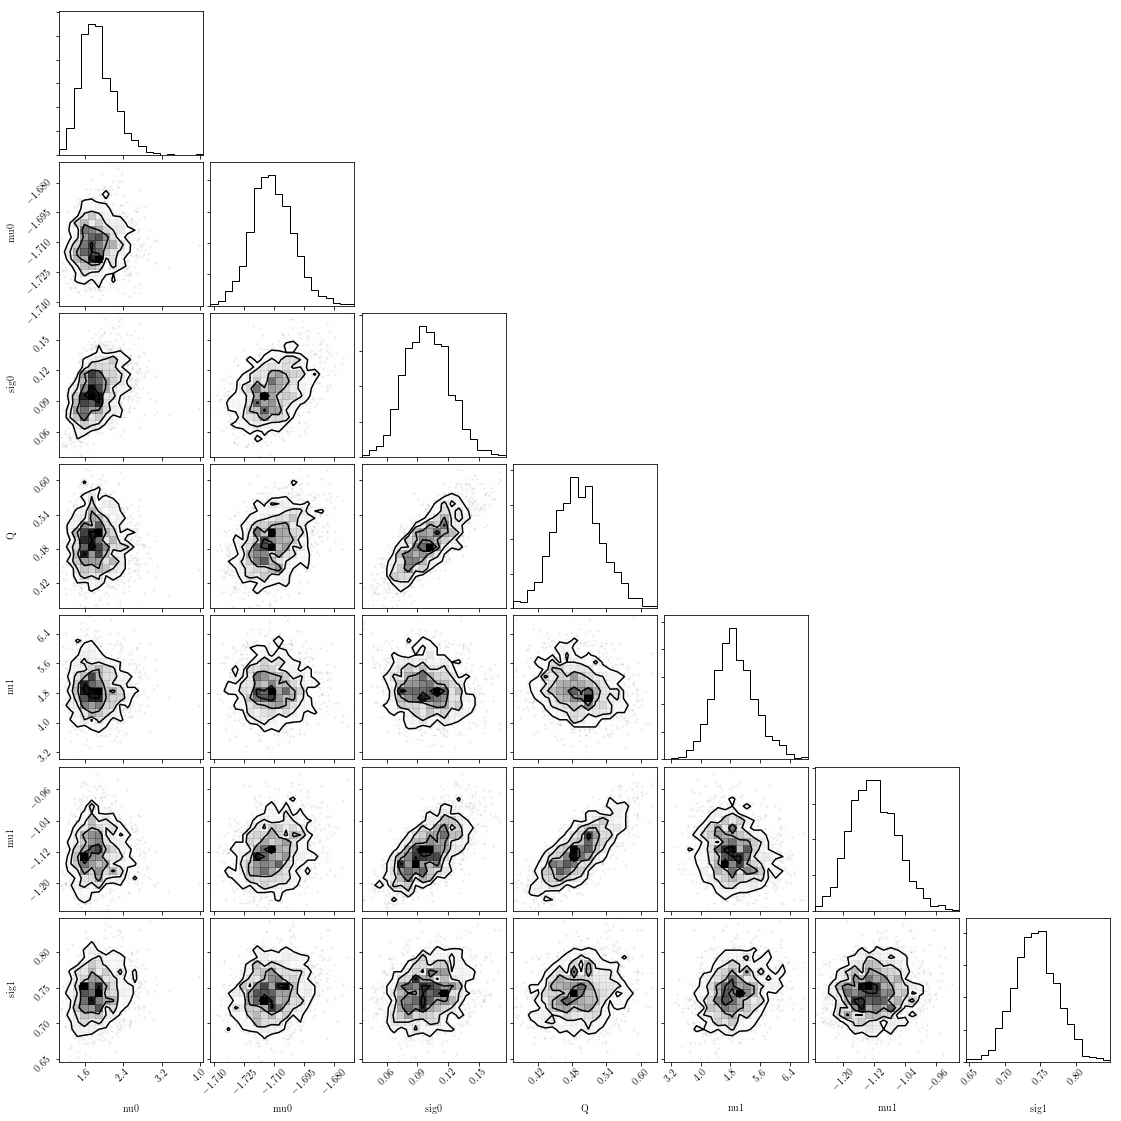

In [8]:
import corner
trace = fit.extract()
chain = np.array([trace['nu0'],trace['mu0'],trace['sig0'],trace['Q'],trace['nu1'],trace['mu1'],trace['sig1']])
corner.corner(chain.T,labels=['nu0','mu0','sig0','Q','nu1','mu1','sig1'])
plt.show()

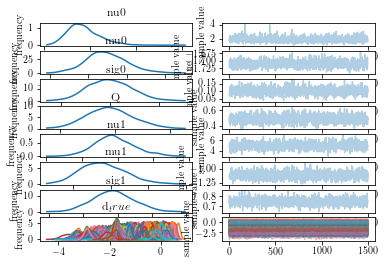

In [9]:
fit.plot(pars=['nu0','mu0','sig0','Q','nu1','mu1','sig1','d_true'])
plt.show()

In [10]:
trace = fit.extract()
nu0 = np.median(trace['nu0'])
mu0 = np.median(trace['mu0'])
sig0 = np.median(trace['sig0'])
Q = np.median(trace['Q'])
nu1 = np.median(trace['nu1'])
mu1 = np.median(trace['mu1'])
sig1 = np.median(trace['sig1'])
post_prob = np.sum(trace['post_prob'],axis=0)/trace['post_prob'].shape[0]
bg_pp = np.sum(trace['bg_postprob'],axis=0)/trace['bg_postprob'].shape[0]


bg = students_t(Ks,nu1,mu1,sig1)
fg = students_t(Ks,nu0,mu0,sig0)
L = Q*fg + (1-Q)*bg

NameError: name 'xax' is not defined

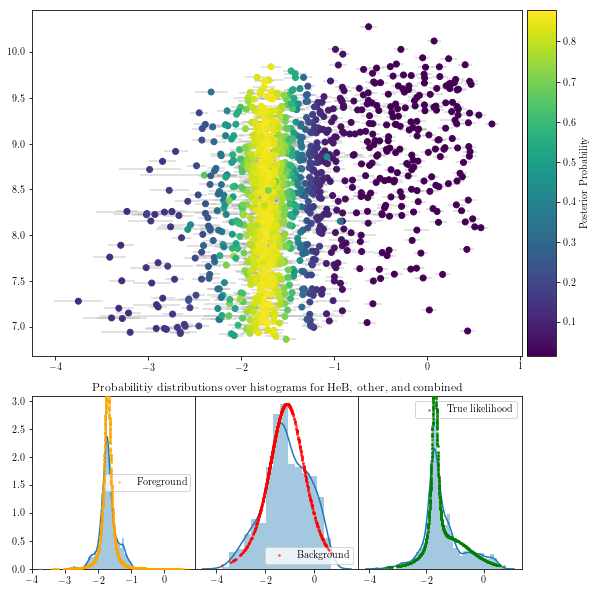

In [11]:
left, bottom, width, height = 0.1, 0.47, 0.85, 0.60
fig = plt.figure(1, figsize=(8,8))
sax = fig.add_axes([left, bottom, width, height])
xax1 = fig.add_axes([left, 0.1, width/3, 0.3])
xax2 = fig.add_axes([left+width/3, 0.1, width/3, 0.3])
xax3 = fig.add_axes([left+2*width/3, 0.1, width/3, 0.3])

cax = fig.add_axes([left+width+0.01, bottom, 0.05, height])
xax2.set_yticks([])
xax3.set_yticks([])
xax2.set_title('Probabilitiy distributions over histograms for HeB, other, and combined')

c = sax.scatter(Ks,mKs,c=post_prob,zorder=1000)
fig.colorbar(c, cax=cax, label='Posterior Probability')
sax.errorbar(Ks,mKs,xerr=Ks_err,c='grey',fmt='none',alpha=.3,zorder=999)

sns.distplot(Ks[heb],ax=xax1)
sns.distplot(Ks[~heb],ax=xax2)
sns.distplot(Ks,ax=xax3)

xax1.scatter(Ks,fg,s=3,label='Foreground', alpha=.5,c='orange',zorder=999)
xax2.scatter(Ks,bg,s=3,label='Background', alpha=.5,c='red',zorder=998)
xax3.scatter(Ks, L,s=3,label='True likelihood', alpha=.5,c='green',zorder=997)
xax1.legend()
xax2.legend()
xax3.legend()

xax.set_xlabel('Absmag in K')
sax.set_ylabel('App mag in K')
xax.set_ylabel('Units arbitrary')

In [12]:
'''Calculate the Kass+Raftery94 lnK values'''
lnK = np.log(post_prob) - np.log(bg_pp)

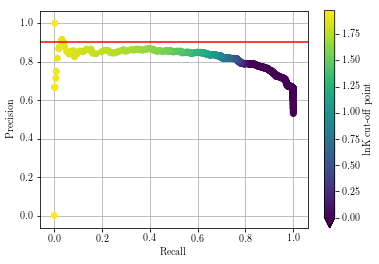

In [13]:
#Calculate recall vs precision for various Kass+Raftery94 cut off scales
recall, precision = [], []
for lim in np.linspace(lnK.min(),lnK.max(),1000):
    mask = lnK > lim
    cheb_correct = len(Ks[mask][stage[mask]==2])
    cheb_total = len(Ks[stage==2])
    identified_total = len(Ks[mask])
    recall.append(float(cheb_correct)/float(cheb_total))
    try:
        precision.append(float(cheb_correct)/float(identified_total))
    except:
        precision.append(0.)
        
fig, ax = plt.subplots()
col = ax.scatter(recall, precision, c=np.linspace(lnK.min(),lnK.max(),1000),vmin=0.)
ax.axhline(0.9,c='r',label='0.9 precision')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.grid()
ax.set_axisbelow(True)
fig.colorbar(col, label='lnK cut-off point',extend='min')
plt.show()        


In [ ]:
import barbershop
%pylab inline
barber = barbershop.open(df,'ast_MKs','M')
barber.add_client('stage')
barber.add_client('logg')
barber.add_client('M')
barber.histograms_on(x=True, y=True)
barber.show_mirror()

In [ ]:
list(df)